# PRONOSTICO ADAPTATIVO PRECIOS


### Librerias

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from random import seed
seed(1) ### Para no variar los aleatorios
%matplotlib inline

## Lectura de datos

In [3]:
init_year = 1995 # a;o incial
last_year = 2018 # a;o final

# DataFrame acumulador de datos con sus columnas
df = pd.DataFrame(
    columns=[
             "Fecha", "0",
             "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", 
             "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", 
             "21", "22", "23" 
    ]
    )
df_per_year = None # DataFrame que obtiene cada archivo
name_file = "" # Variable para alternar la ruta desde 2016
skiprows = 3

# Lectura por archivo
for year in range(init_year, last_year + 1):
  if year >= 2016 :
    name_file = "https://github.com/ANN-2019-2/evaluacion-cdbolivarz/blob/master/datos/precios/Precio_Bolsa_Nacional_($kwh)_"+str(year)+".xls?raw=true"
  else:
    name_file = "https://github.com/ANN-2019-2/evaluacion-cdbolivarz/blob/master/datos/precios/Precio_Bolsa_Nacional_($kwh)_"+str(year)+".xlsx?raw=true"

  skiprows = 3 if year < 2000 else 2

  df_per_year = pd.read_excel(
    io = name_file,
    header = 0,
    dtype = {
        "Fecha": np.datetime64,
        "0": np.float64,
        "1": np.float64, "2": np.float64, "3": np.float64, "4": np.float64, "5": np.float64, "6": np.float64, "7": np.float64, 
        "8": np.float64, "9": np.float64, "10": np.float64, "11": np.float64, "12": np.float64, "13": np.float64, "14": np.float64, 
        "15": np.float64, "16": np.float64, "17": np.float64, "18": np.float64, "19": np.float64, "20": np.float64, "21": np.float64, 
        "22": np.float64, "23": np.float64
    },
    usecols = "A:Y", 
    skiprows = skiprows #Para el primer archivo el primer mes no esta completo.
    )
  df = df.append(df_per_year, ignore_index=True, sort=False)

df.head()

,Fecha,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1995-07-20,NaN,1.073,1.073,1.073,1.073,1.073,1.073,1.073,1.074,1.074,2.827,2.827,2.827,1.074,1.073,1.073,1.073,1.073,1.074,1.897,1.897,1.897,1.073,1.073
1,1995-07-21,1.073,1.000,1.000,1.000,1.000,1.000,5.000,6.000,6.000,6.000,6.000,9.256,9.256,5.000,5.000,1.000,1.000,5.000,12.000,16.670,11.929,5.000,1.000,1.000
2,1995-07-22,1.073,1.073,1.000,1.000,1.000,1.073,1.303,1.303,1.303,1.303,1.303,1.303,1.303,1.303,1.073,1.000,1.000,1.000,1.303,2.500,2.500,1.303,1.073,1.073
3,1995-07-23,1.073,1.000,1.000,1.000,1.000,1.000,0.100,1.000,1.000,1.000,1.000,1.000,1.238,1.238,1.000,0.100,0.100,1.000,1.238,1.238,1.238,1.238,1.073,1.000
4,1995-07-24,1.000,1.000,0.990,1.000,1.000,1.073,3.000,3.000,3.000,3.500,8.845,9.256,3.000,1.073,1.073,1.073,3.000,2.000,18.630,22.500,9.256,3.000,1.073,1.000


Calculo de columna promedio $\$/kWh$ por dia

In [4]:
df['Promedio $/kWh'] = (df.loc[:, df.columns != 'Fecha']).mean(axis=1, skipna=True) # Promedio por fila sin tener en cuenta nulos y se excluye la fecha
(df[['Fecha', 'Promedio $/kWh']]).head()

,Fecha,Promedio $/kWh
0,1995-07-20,1.409435
1,1995-07-21,4.924333
2,1995-07-22,1.269500
3,1995-07-23,0.953083
4,1995-07-24,4.305917


## Preprocesamiento
Lectura del IPC mensual

In [5]:
df_ipc = pd.read_excel(
    io = "https://github.com/ANN-2019-2/evaluacion-cdbolivarz/blob/master/SolucionPrecios01/InflacionMensual.xlsx?raw=true",
    header = 0,
    dtype = {
        "Año(aaaa)-Mes(mm)": np.dtype(str),
        "Inflación mensual": np.float64
    },
    usecols = "A,D",
    skiprows = 12
    )
df_ipc["IPC"] = np.add(1, df_ipc["Inflación mensual"]) # Se lleva a porcentaje 
df_ipc["Mes"] = df_ipc["Año(aaaa)-Mes(mm)"].str[4:6]
df_ipc["Ano"] = df_ipc["Año(aaaa)-Mes(mm)"].str[0:4]
df_ipc = df_ipc.dropna(subset=['IPC'])
df_ipc = df_ipc.iloc[::-1]
df_ipc.head()

,Año(aaaa)-Mes(mm),Inflación mensual,IPC,Mes,Ano
274,199507,0.0000,1.0000,07,1995
273,199508,0.0063,1.0063,08,1995
272,199509,0.0084,1.0084,09,1995
271,199510,0.0088,1.0088,10,1995
270,199511,0.0079,1.0079,11,1995


Se llevan todos los precios del $\frac{\$}{kWh}$ a valor presente

In [6]:
df = df.dropna(subset=['Fecha']) # Si la fecha es nula en alguna fila, se descarta el dato
N = df["Fecha"].size # Tamano dataframe

index = 0 # Indice para indexar el historico IPC por mes
ipc_acum = 0 #Producto acumualdo de incrementos para llevar a precio actual
df["IPC ACUM"] = np.ones(N) # IPC con el incremento acumulado (resultado productoria)

for j, date in df.iterrows():
  try:
    if df.loc[j, "Fecha"].month != int(df_ipc.iloc[index]["Mes"]): # Si cambia el mes, pasa al con el siguiente
      index = index + 1;
    ipc_acum = np.prod(df_ipc.iloc[index:]["IPC"]);
  except:
    ipc_acum = 1
  df.loc[j, "IPC ACUM"] = ipc_acum

df["Valor presente"] =  df['Promedio $/kWh'] * df["IPC ACUM"]
(df[['Fecha', 'Valor presente', 'IPC ACUM']]).head()

,Fecha,Valor presente,IPC ACUM
0,1995-07-20,6.663727,4.727943
1,1995-07-21,23.281966,4.727943
2,1995-07-22,6.002123,4.727943
3,1995-07-23,4.506123,4.727943
4,1995-07-24,20.358127,4.727943


Funciones de escalado de datos

In [0]:
minmax = [] # lista en la que cada fila sera un diccionario con el nombre, minimo y maximo de la transformacion
def scaler(name):
  min_value = fit_df[name].min()
  max_value = fit_df[name].max() 
  minmax.append({
      "name": name,
      "min_value": min_value,
      "max_value": max_value
  })

  return (fit_df[name] - min_value)/(max_value - min_value)

# Desnormalizar pronostico
def des_scaler(name, X):
  X = np.array(X)
  for transf in minmax:
    if transf["name"] == name:
      return np.add(np.dot(X, (transf["max_value"] - transf["min_value"])), transf["min_value"]);

## Creacion del modelo

In [0]:
class Adaline:
    def __init__(self,
                 learning_rate=0.001, # tasa de aprendizaje
                 momentum=0.001,      # momentum 
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state = 420,   # Semilla numero aleatorio
                 warm_start=False):   #

        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        np.random.seed(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(0, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(0, 1, 1)

        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n)
                X = X[n,:]
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_
                e = (d[i] - u)[0]
                self.coef_ += 2 * self.learning_rate * e * X[i,:] + self.coef_*self.momentum # Se agrega el termino del momentum
                self.intercept_ += 2 * self.learning_rate * e
                errors2.append(e**2)
                forecasts.append(u)

        return errors2, forecasts

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u



### Familia de transformaciones
Funciones consideradas: 
* $f(x) = ln(x)$
* $g(x) = \frac {1}{ln(x)}$
* $h(x) = \sqrt x$
* $i(x) = x^2$
* $j(x) = \frac{1}{x}$
* $k(x) = {\rm e}^{\frac {x}{x+1}}$
* $m(x) = \frac {1}{\sin (x)}$ 
* $n(x) = \sin(\sqrt x)$
* $p(x) = \sqrt[4] {x} $

Se aplican las funciones al dato $\$/kWh$


In [0]:
df['f'], df['g'], df['h'] = np.log(df['Valor presente']), np.divide(1, np.log(df['Valor presente'])), np.sqrt(df['Valor presente'])
df['i'], df['j'] = np.power(df['Valor presente'], 2), np.divide(1, df['Valor presente'])
df['k'] =  np.exp(df['Valor presente']/(df['Valor presente'] + 1))
df['m'] = np.divide(1, np.sin(df['Valor presente']))
df['n'], df['p'] = np.sin(np.sqrt(df['Valor presente'])), np.power(df['Valor presente'], 1/4)

## Grafica transformaciones

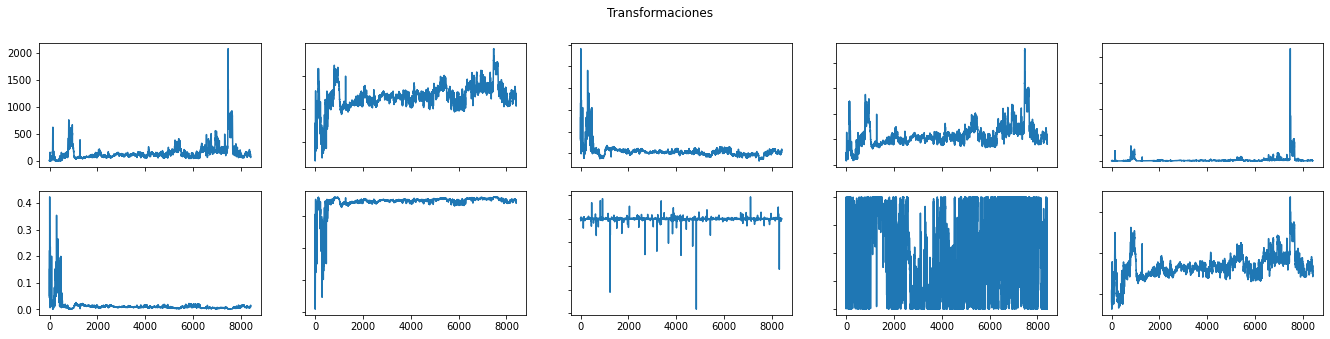

In [0]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(23,5))
fig.suptitle('Transformaciones')
ax1.plot(df['Valor presente'])
ax2.plot(df['f'])
ax3.plot(df['g'])
ax4.plot(df['h'])
ax5.plot(df['i'])
ax6.plot(df['j'])
ax7.plot(df['k'])
ax8.plot(df['m'])
ax9.plot(df['n'])
ax10.plot(df['p'])

for ax in fig.get_axes():
    ax.label_outer()

Las funciones trigonometricas en este caso muestran un comportamiento no deseado(excesivamente oscilante), para el modelo se tendran en cuenta: $f(x)$, $h(x)$ y $p(x)$ .

## Funciones inversas

In [0]:
def inv(name, X):
  if name == "f":
    return np.exp(X)
  elif name == "h":
    return np.power(X, 2)
  elif name == "p":
    return np.power(X, 4)
  else:
    return X


## Separacion de datos para entrenamiento, test y para pronostico.

In [0]:
columns = ['Valor presente', 'f', 'h', 'p']
N = df['Valor presente'].size # Cantidad de datos
minmax = []

fit_df = pd.DataFrame(columns=columns)
predict = df.iloc[(N - 7):]['Valor presente'] # Datos a pronosticar

for column in columns: 
  fit_df[column] = df[column][:(N - 7)] # Datos para el entrenamiento
  # Normalizacion
  fit_df[column] = scaler(column)

Entrenamiento modelo con distintos parametros
* Realizando pruebas se determino que la taza de aprendizaje y el momentum deben estar entre de $0.001$ a $0.1$ y $0.0001$ a $0.001$ respectivamente

In [12]:
Ls = list(range(7, 10)) # Rezago
result_df = pd.DataFrame(columns = ["Modelo","ECM pronostico","ECM entrenamiento","L optimo","Momentum optimo","Tasa a. optima","Error", "Pronostico"])
for column in columns:
  min_e_p = 10000000000 # pronostico
  e_fit = 0 # error de entrenamiento
  opt_momentum = 0
  opt_learning_rate = 0
  out_fit = []
  L_opt = 7
  P_opt = []
  for L in Ls: 
    for momentum in np.arange(0.0000,0.001, 0.0005):
      for learning_rate in np.arange(0.005, 0.1, 0.005): # Se toma hasta 0.1 por el pico que puede generar un error muy grande si se toman momentums mayores
        X = [] # Forma la matriz para el entrenamiento
        P = [] # Pronosticos
        for t in range(L, len(fit_df[column])):
          X.append(fit_df[column][t-L:t].copy())

        # Instancia del modelo
        adaline = Adaline(
          learning_rate=learning_rate,  # tasa de aprendizaje
          momentum = momentum, # Momentum
          max_epochs=1,        # número máximo de iteraciones sobre el set de datos
          shuffle=False,       # mezcla patrones para aprendizaje online
          random_state=420,    # corrida reproducible
          warm_start=False)    # inicia con pesos aleatorios
        errors2, forecasts = adaline.fit(X, fit_df[column][L:]) # Entrenamiento

        # Pronostico siguientes 7 dias
        for i in range(7):
          u = adaline.predict(X[-1]) # prediccion siguiente dia
          next_X = np.append(X[-1][1:L], [u]) # Se agrega una nueva fila con el valor pronosticado
          X = np.concatenate( ( X, [next_X] ), axis=0) # Se concatena a la lista de datos
          P.append(u[0]) # Almacena el pronostico

        # Desnormalizacion y transf. inversa del pronostico
        P = des_scaler(column, P) # Devuelve desnormalizacion de la transformacion
        P = inv(column, P) # Devuelve la inversa de la funcion

        e = np.sum(errors2)/len(errors2) # ECM aprendizaje
        e_p = np.sum(np.power(np.array(predict) - P, 2))/7 # ECM Pronostico

        if (e_p < min_e_p): # Encuentra un error menor
          min_e_p = e_p # actualiza error minimo
          e_fit = e # error entrenamiento
          opt_momentum = momentum # actualiza momentum optimo
          opt_learning_rate = learning_rate # tasa de aprendizaje optima
          out_fit = errors2 # Grafica entrenamiento
          L_opt = L
          P_opt = P

  result_df = result_df.append(
        {
          "Modelo": column,
          "ECM pronostico": min_e_p,
          "ECM entrenamiento": e_fit,
          "L optimo": L_opt,
          "Momentum optimo": opt_momentum,
          "Tasa a. optima": opt_learning_rate,
          "Error": out_fit,
          "Pronostico": P_opt
      },
      ignore_index=True
  )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in power


In [13]:
result_df

,Modelo,ECM pronostico,ECM entrenamiento,L optimo,Momentum optimo,Tasa a. optima,Error,Pronostico
0,Valor presente,178.324759,0.001464,7,0.0,0.015,"[0.006737947423416151, 0.005255544105771619, 0...","[93.37454398385628, 90.25859492574087, 90.2944..."
1,f,294.246659,0.003944,7,0.0,0.005,"[0.4717588429782201, 0.22756303958736104, 0.06...","[97.36352033732766, 95.02187804318078, 94.7468..."
2,h,196.067419,0.003796,7,0.0,0.005,"[0.03568756354059646, 0.01874114048035168, 0.0...","[95.54354104962336, 92.54708145452787, 91.7302..."
3,p,214.243082,0.003926,7,0.0,0.005,"[0.1351516257227328, 0.06393135053883803, 0.02...","[95.90704200844736, 93.18071045699192, 92.4453..."


Segun los resultados, el que mejor estima los proximos 7 dias es la funcion original. Ya que tiene menor error de entrenamiento y de pronostico, con un momentum de $0.0$ y tasa de aprendizaje $0.015$

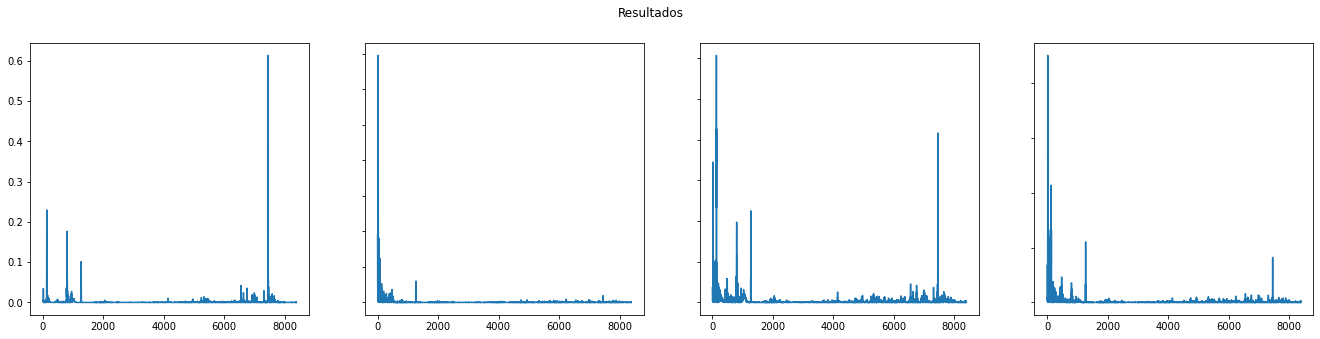

In [14]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(23,5))
fig.suptitle('Resultados')
ax1.plot(result_df.loc[0, 'Error'])
ax2.plot(result_df.loc[1, 'Error'])
ax3.plot(result_df.loc[2, 'Error'])
ax4.plot(result_df.loc[3, 'Error'])

for ax in fig.get_axes():
    ax.label_outer()

## Pronistico siguientes 7 dias con el modelo escojido

In [22]:
df_comp = pd.DataFrame(columns = ["Fecha","Real", "Pronostico"]) 
df_comp["Fecha"] = np.array(df.iloc[(N - 7):]['Fecha'])
df_comp["Real"] = np.array(predict)
df_comp["Pronostico"] = result_df.loc[0, 'Pronostico']
df_comp

,Fecha,Real,Pronostico
0,2018-04-29,70.595019,93.374544
1,2018-04-30,94.687618,90.258595
2,2018-05-01,71.666726,90.294403
3,2018-05-02,76.374441,84.196734
4,2018-05-03,71.148348,77.308037
5,2018-05-04,64.710120,69.518165
6,2018-05-05,73.972085,58.463615
